# BFGS Experimental Notebook

## Setup

### Imports

In [2]:
import numpy as np
from numpy import linalg as la
from scipy.optimize import line_search as off_shelf_line_search
from scipy.optimize import minimize
import pandas

from bfgs_funcs import Funcs
from bfgs import BFGS

import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go

### Data Generation

#### Load Data

In [3]:
# load the matrix
M1 = np.loadtxt('../data/M1.txt')
x0_m1 = np.loadtxt('../data/x0_m1.txt')
M2 = np.loadtxt('../data/M2.txt')
x0_m2 = np.loadtxt('../data/x0_m2.txt')
M3 = np.loadtxt('../data/M3.txt')
x0_m3 = np.loadtxt('../data/x0_m3.txt')
M4 = np.loadtxt('../data/M4.txt')
x0_m4 = np.loadtxt('../data/x0_m4.txt')
M5 = np.loadtxt('../data/M5.txt')
x0_m5 = np.loadtxt('../data/x0_m5.txt')

In [4]:
M1.shape, M2.shape, M3.shape, M4.shape, M5.shape

((1000, 1000),
 (10000, 100),
 (100, 1000),
 (100, 100),
 (1000, 100),
 (1000, 1000))

### Utils Functions

In [5]:
def error_report(matrix, fx, residuals, errors, max_iter = 1000, plot=False):
    computed_norm = np.sqrt(- fx)
    correct_norm = la.norm(matrix, 2)
    error = abs(correct_norm - computed_norm)
    
    num_iterations = len(residuals)
    if num_iterations != max_iter:
        print("Convergence reached in " + str(num_iterations) + " iterations")
    else:
        print("Convergence not reached")

    print("Computed Norm: " + str(computed_norm))
    print("True Norm: " + str(correct_norm))
    print("Error: " + str(error))
    
    if plot:
        fig = make_subplots(rows=1, cols=2, shared_xaxes=False)
        fig.add_trace( go.Scatter(x=list(range(0,len(errors))), y=errors,name="Errors"),
            row=1, col=1)
        fig.add_trace(
            go.Scatter(x=list(range(0,len(residuals))), y=residuals,name="Residuals"), row=1, col=2
        )
        fig.update_xaxes(title_text="Iterations", row=1, col=1)
        fig.update_yaxes(title_text="Error", row=1, col=1)
        fig.update_xaxes(title_text="Iterations", row=1, col=2)
        fig.update_yaxes(title_text="Residual", row=1, col=2)
        fig.update_layout(height=500, width=1000,title_text="Residual and Error plot").show()

In [6]:
def run_bfgs(matrix, starting_point, c1=1e-4, c2=0.9, alg_method='O', ls_method='W', max_iter=1000, verbose=False, plot=False, return_arrays=False):
    funcs = Funcs(matrix)
    B0 = np.identity(matrix.shape[1])
    
    if ls_method == 'W':
        line_search_args = {'c1': c1, 'c2': c2}
    else:
        line_search_args = {'c1': c1}
        
    line_search_method = funcs.line_search_methods[ls_method]

    # Initialize the BFGS algorithm.
    bfgs = BFGS(funcs.func_, funcs.func_grad_, line_search_method, starting_point, B0, tol=1e-5, max_iter=max_iter, method=alg_method, line_search_args=line_search_args, verbose=verbose)

    # Run the algorithm.
    residuals, errors, result = bfgs.bfgs()

    # Evalutate Performance of the Single Run
    error_report(matrix, result, residuals, errors, max_iter=max_iter, plot=plot)
    
    if return_arrays:
        return bfgs, residuals, errors
    return bfgs

In [7]:
def off_shelf_opt(matrix, vector, method='BFGS'):
    funcs = Funcs(matrix)
    res = minimize(funcs.func_, vector, method=method, jac=funcs.func_grad_, tol=1e-5, options={'gtol': 1e-6, 'disp': False})
    fx = res.fun
    
    num_iterations = res.nit
    if res.success:
        print("Convergence reached in " + str(num_iterations) + " iterations")
    else:
        print("Convergence not reached")
    
    computed_norm = np.sqrt(-fx)
    correct_norm = la.norm(matrix, 2)
    error = abs(computed_norm - correct_norm)
    
    print("Computed Norm: " + str(computed_norm))
    print("True Norm: " + str(correct_norm))
    print("Error: " + str(error))

In [8]:
labels_list = ["Wolfe_A", "Wolfe_B", "Armijo_A", "Armijo_B"]

def plot_summary(errors_list, residuals_list, labels_list, matrix_name, method_name):
    font = {'family':'serif','color':'black','size':10}
    
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    for i in range(len(errors_list)):
        x = list(range(len(errors_list[i])))
        axs[0].plot(x, errors_list[i], label = labels_list[i])
        axs[1].plot(x, residuals_list[i], label = labels_list[i])
    
    axs[0].legend()
    axs[1].legend()
    axs[0].set_yscale('log')
    axs[1].set_yscale('log')
    axs[0].set_xlabel("Iterations")
    axs[0].set_ylabel("Error")
    axs[1].set_xlabel("Iterations")
    axs[1].set_ylabel("Residual")
    fig.suptitle(matrix_name + " " + method_name + " Residual and Error plot")

## M1 Matrix

### Original BFGS

In [9]:
o_m1_errors_list = []
o_m1_residuals_list = []

#### Base performance with loaded starting point (Wolfe-type line search)

In [10]:
w_o_m1_bfgs_a, w_o_m1_residuals_a, w_o_m1_errors_a = run_bfgs(M1, x0_m1, alg_method='O', ls_method='W', c1=1e-4, c2=0.9, return_arrays=True)
o_m1_errors_list.append(w_o_m1_errors_a)
o_m1_residuals_list.append(w_o_m1_residuals_a)

Convergence reached in 357 iterations
Computed Norm: 72.40864404748753
True Norm: 72.40864404756124
Error: 7.371170340775279e-11


In [11]:
w_o_m1_bfgs_b, w_o_m1_residuals_b, w_o_m1_errors_b = run_bfgs(M1, x0_m1, alg_method='O', ls_method='W', c1=0.1, c2=0.49, return_arrays=True)
o_m1_errors_list.append(w_o_m1_errors_b)
o_m1_residuals_list.append(w_o_m1_residuals_b)

Convergence reached in 225 iterations
Computed Norm: 72.4086440474715
True Norm: 72.40864404756124
Error: 8.974154752650065e-11


#### Base performance with loaded starting point (Armijo-type line search)

In [12]:
a_o_m1_bfgs_a, a_o_m1_residuals_a, a_o_m1_errors_a = run_bfgs(M1, x0_m1, alg_method='O', ls_method='A', c1=1e-4, return_arrays=True)
o_m1_errors_list.append(a_o_m1_errors_a)
o_m1_residuals_list.append(a_o_m1_residuals_a)

Convergence reached in 357 iterations
Computed Norm: 72.4086440474897
True Norm: 72.40864404756124
Error: 7.153744263632689e-11


In [13]:
a_o_m1_bfgs_b, a_o_m1_residuals_b, a_o_m1_errors_b = run_bfgs(M1, x0_m1, alg_method='O', ls_method='A', c1=0.1, return_arrays=True)
o_m1_errors_list.append(a_o_m1_errors_b)
o_m1_residuals_list.append(a_o_m1_residuals_b)

Convergence reached in 357 iterations
Computed Norm: 72.4086440474897
True Norm: 72.40864404756124
Error: 7.153744263632689e-11


#### Summary for Original BFGS

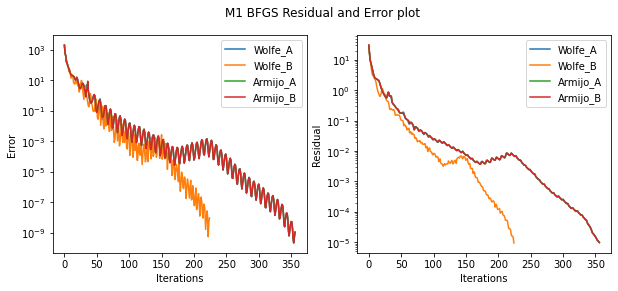

In [14]:
plot_summary(o_m1_errors_list, o_m1_residuals_list, labels_list, "M1", "BFGS")

#### Average runtime over 10 runs (Wolfe-type line search)

In [15]:
%%timeit -r 10
# Measuring running time
w_o_m1_bfgs_a.bfgs()

50.2 s ± 276 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


In [16]:
%%timeit -r 10
# Measuring running time
w_o_m1_bfgs_b.bfgs()

32.1 s ± 283 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


#### Average runtime over 10 runs (Armijo-type line search)

In [17]:
%%timeit -r 10
# Measuring running time
a_o_m1_bfgs_a.bfgs()

47.8 s ± 250 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


In [18]:
%%timeit -r 10
# Measuring running time
a_o_m1_bfgs_b.bfgs()

47.6 s ± 1.5 s per loop (mean ± std. dev. of 10 runs, 1 loop each)


#### Comparison with off-shelf BFGS minimizer

In [19]:
off_shelf_opt(M1, x0_m1)
funcs = Funcs(M1)

Convergence reached in 422 iterations
Computed Norm: 72.40864404749024
True Norm: 72.40864404756124
Error: 7.099743015714921e-11


In [20]:
%%timeit -r 10
# Measuring running time
minimize(funcs.func_, x0_m1, method='BFGS', jac=funcs.func_grad_, options={'gtol': 1e-6, 'disp': False})

49.5 s ± 507 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


#### Comparison with off-shelf norm function

In [21]:
%%timeit -r 10
# Measuring running time
la.norm(M1, 2)

523 ms ± 22 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


### Cautious BFGS

In [22]:
c_m1_errors_list = []
c_m1_residuals_list = []

#### Base performance with loaded starting point (Wolfe-type line search)

In [23]:
w_c_m1_bfgs_a, w_c_m1_residuals_a, w_c_m1_errors_a = run_bfgs(M1, x0_m1, alg_method='C', ls_method='W', c1=1e-4, c2=0.9, return_arrays=True)
c_m1_errors_list.append(w_c_m1_errors_a)
c_m1_residuals_list.append(w_c_m1_residuals_a)

Convergence reached in 124 iterations
Computed Norm: 72.40864404755862
True Norm: 72.40864404756124
Error: 2.6147972675971687e-12


In [24]:
w_c_m1_bfgs_b, w_c_m1_residuals_b, w_c_m1_errors_b = run_bfgs(M1, x0_m1, alg_method='C', ls_method='W', c1=0.1, c2=0.49, return_arrays=True)
c_m1_errors_list.append(w_c_m1_errors_b)
c_m1_residuals_list.append(w_c_m1_residuals_b)

Convergence reached in 131 iterations
Computed Norm: 72.40864404755564
True Norm: 72.40864404756124
Error: 5.5990767577895895e-12


#### Base performance with loaded starting point (Armijo-type line search)

In [25]:
a_c_m1_bfgs_a, a_c_m1_residuals_a, a_c_m1_errors_a = run_bfgs(M1, x0_m1, alg_method='C', ls_method='A', c1=1e-4, return_arrays=True)
c_m1_errors_list.append(a_c_m1_errors_a)
c_m1_residuals_list.append(a_c_m1_residuals_a)

Convergence reached in 158 iterations
Computed Norm: 72.40864404755884
True Norm: 72.40864404756124
Error: 2.4016344468691386e-12


In [26]:
a_c_m1_bfgs_b, a_c_m1_residuals_b, a_c_m1_errors_b = run_bfgs(M1, x0_m1, alg_method='C', ls_method='A', c1=0.1, return_arrays=True)
c_m1_errors_list.append(a_c_m1_errors_b)
c_m1_residuals_list.append(a_c_m1_residuals_b)

Convergence reached in 158 iterations
Computed Norm: 72.40864404755884
True Norm: 72.40864404756124
Error: 2.4016344468691386e-12


#### Summary for Cautious BFGS

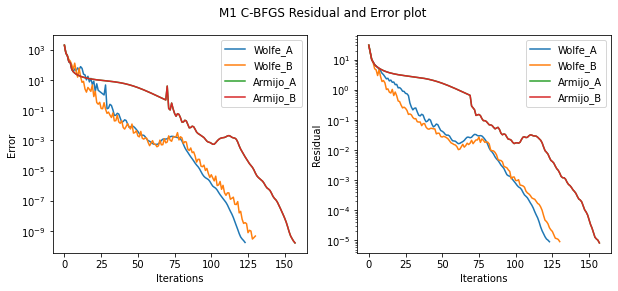

In [27]:
plot_summary(c_m1_errors_list, c_m1_residuals_list, labels_list, "M1", "C-BFGS")

#### Average runtime over 10 runs (Wolfe-type line search)

In [28]:
%%timeit -r 10
# Measuring running time
w_c_m1_bfgs_a.bfgs()

12.1 s ± 148 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


In [29]:
%%timeit -r 10
# Measuring running time
w_c_m1_bfgs_b.bfgs()

15.5 s ± 157 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


#### Average runtime over 10 runs (Armijo-type line search)

In [30]:
%%timeit -r 10
# Measuring running time
a_c_m1_bfgs_a.bfgs()

12.9 s ± 140 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


In [31]:
%%timeit -r 10
# Measuring running time
a_c_m1_bfgs_b.bfgs()

12.7 s ± 147 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


## M2 Matrix

### Original BFGS

In [32]:
o_m2_errors_list = []
o_m2_residuals_list = []

#### Base performance with loaded starting point (Wolfe-type line search)

In [33]:
w_o_m2_bfgs_a, w_o_m2_residuals_a, w_o_m2_errors_a = run_bfgs(M2, x0_m2, alg_method='O', ls_method='W', c1=1e-4, c2=0.9, return_arrays=True)
o_m2_errors_list.append(w_o_m2_errors_a)
o_m2_residuals_list.append(w_o_m2_residuals_a)

Convergence reached in 445 iterations
Computed Norm: 109.46751097802968
True Norm: 109.46751097963192
Error: 1.6022454474295955e-09


In [34]:
w_o_m2_bfgs_b, w_o_m2_residuals_b, w_o_m2_errors_b = run_bfgs(M2, x0_m2, alg_method='O', ls_method='W', c1=0.1, c2=0.49, return_arrays=True)
o_m2_errors_list.append(w_o_m2_errors_b)
o_m2_residuals_list.append(w_o_m2_residuals_b)

Convergence reached in 169 iterations
Computed Norm: 109.46751097956667
True Norm: 109.46751097963192
Error: 6.52562448522076e-11


#### Base performance with loaded starting point (Armijo-type line search)

In [35]:
a_o_m2_bfgs_a, a_o_m2_residuals_a, a_o_m2_errors_a = run_bfgs(M2, x0_m2, alg_method='O', ls_method='A', c1=1e-4, return_arrays=True)
o_m2_errors_list.append(a_o_m2_errors_a)
o_m2_residuals_list.append(a_o_m2_residuals_a)

Convergence reached in 440 iterations
Computed Norm: 109.46751097793373
True Norm: 109.46751097963192
Error: 1.6981971384666394e-09


In [36]:
a_o_m2_bfgs_b, a_o_m2_residuals_b, a_o_m2_errors_b = run_bfgs(M2, x0_m2, alg_method='O', ls_method='A', c1=0.1, return_arrays=True)
o_m2_errors_list.append(a_o_m2_errors_b)
o_m2_residuals_list.append(a_o_m2_residuals_b)

Convergence reached in 241 iterations
Computed Norm: 109.46751097958969
True Norm: 109.46751097963192
Error: 4.2234660213580355e-11


#### Summary for Original BFGS

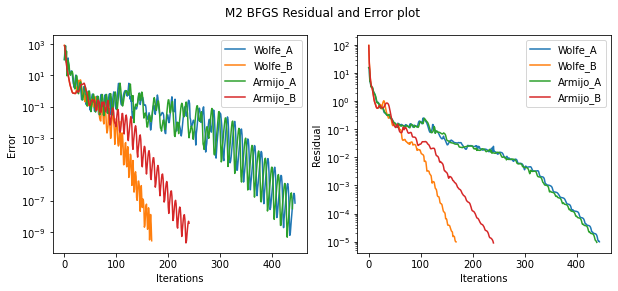

In [37]:
plot_summary(o_m2_errors_list, o_m2_residuals_list, labels_list, "M2", "BFGS")

#### Average runtime over 10 runs (Wolfe-type line search)

In [38]:
%%timeit -r 10
# Measuring running time
w_o_m2_bfgs_a.bfgs()

243 ms ± 11.3 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


In [39]:
%%timeit -r 10
# Measuring running time
w_o_m2_bfgs_b.bfgs()

109 ms ± 18.3 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


#### Average runtime over 10 runs (Armijo-type line search)

In [40]:
%%timeit -r 10
# Measuring running time
a_o_m2_bfgs_a.bfgs()

232 ms ± 19.1 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


In [41]:
%%timeit -r 10
# Measuring running time
a_o_m2_bfgs_b.bfgs()

128 ms ± 12.7 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


#### Comparison with off-shelf BFGS minimizer

In [42]:
off_shelf_opt(M2, x0_m2)
funcs = Funcs(M2)

Convergence not reached
Computed Norm: 109.43610778289376
True Norm: 109.46751097963192
Error: 0.03140319673816805


In [43]:
%%timeit -r 10
# Measuring running time
minimize(funcs.func_, x0_m2, method='BFGS', jac=funcs.func_grad_, options={'gtol': 1e-6, 'disp': False})

46.7 ms ± 11 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


#### Comparisonwith off-shelf norm function

In [44]:
%%timeit -r 10
# Measuring running time
la.norm(M2, 2)

78.8 ms ± 2.01 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


### Cautious BFGS

In [45]:
c_m2_errors_list = []
c_m2_residuals_list = []

#### Base performance with loaded starting point (Wolfe-type line search)

In [46]:
w_c_m2_bfgs_a, w_c_m2_residuals_a, w_c_m2_errors_a = run_bfgs(M2, x0_m2, alg_method='C', ls_method='W', c1=1e-4, c2=0.9, return_arrays=True)
c_m2_errors_list.append(w_c_m2_errors_a)
c_m2_residuals_list.append(w_c_m2_residuals_a)

Convergence reached in 284 iterations
Computed Norm: 109.46751097952577
True Norm: 109.46751097963192
Error: 1.0615508472255897e-10


In [47]:
w_c_m2_bfgs_b, w_c_m2_residuals_b, w_c_m2_errors_b = run_bfgs(M2, x0_m2, alg_method='C', ls_method='W', c1=0.1, c2=0.49, return_arrays=True)
c_m2_errors_list.append(w_c_m2_errors_b)
c_m2_residuals_list.append(w_c_m2_residuals_b)

Convergence reached in 113 iterations
Computed Norm: 109.46751097962832
True Norm: 109.46751097963192
Error: 3.609557097661309e-12


#### Base performance with loaded starting point (Armijo-type line search)

In [48]:
a_c_m2_bfgs_a, a_c_m2_residuals_a, a_c_m2_errors_a = run_bfgs(M2, x0_m2, alg_method='C', ls_method='A', c1=1e-4, return_arrays=True)
c_m2_errors_list.append(a_c_m2_errors_a)
c_m2_residuals_list.append(a_c_m2_residuals_a)

Convergence reached in 787 iterations
Computed Norm: 109.46751097961493
True Norm: 109.46751097963192
Error: 1.6996182239381596e-11


In [49]:
a_c_m2_bfgs_b, a_c_m2_residuals_b, a_c_m2_errors_b = run_bfgs(M2, x0_m2, alg_method='C', ls_method='A', c1=0.1, return_arrays=True)
c_m2_errors_list.append(a_c_m2_errors_b)
c_m2_residuals_list.append(a_c_m2_residuals_b)

Convergence reached in 342 iterations
Computed Norm: 109.46751097963069
True Norm: 109.46751097963192
Error: 1.2363443602225743e-12


#### Summary for Cautious BFGS

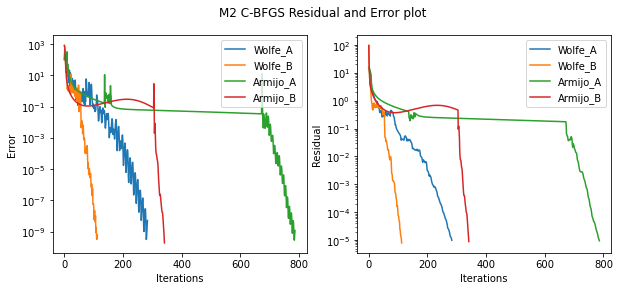

In [50]:
plot_summary(c_m2_errors_list, c_m2_residuals_list, labels_list, "M2", "C-BFGS")

#### Average runtime over 10 runs (Wolfe-type line search)

In [51]:
%%timeit -r 10
# Measuring running time
w_c_m2_bfgs_a.bfgs()

149 ms ± 14.6 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


In [52]:
%%timeit -r 10
# Measuring running time
w_c_m2_bfgs_b.bfgs()

64.2 ms ± 1.74 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


#### Average runtime over 10 runs (Armijo-type line search)

In [53]:
%%timeit -r 10
# Measuring running time
a_c_m2_bfgs_a.bfgs()

198 ms ± 10.4 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


In [54]:
%%timeit -r 10
# Measuring running time
a_c_m2_bfgs_b.bfgs()

81.2 ms ± 2.29 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


## M3 Matrix

### Original BFGS

In [55]:
o_m3_errors_list = []
o_m3_residuals_list = []

#### Base performance with loaded starting point (Wolfe-type line search)

In [56]:
w_o_m3_bfgs_a, w_o_m3_residuals_a, w_o_m3_errors_a = run_bfgs(M3, x0_m3, alg_method='O', ls_method='W', c1=1e-4, c2=0.9, return_arrays=True)
o_m3_errors_list.append(w_o_m3_errors_a)
o_m3_residuals_list.append(w_o_m3_residuals_a)

Convergence reached in 265 iterations
Computed Norm: 41.065553272377436
True Norm: 41.06555327364635
Error: 1.2689156392298173e-09


In [57]:
w_o_m3_bfgs_b, w_o_m3_residuals_b, w_o_m3_errors_b = run_bfgs(M3, x0_m3, alg_method='O', ls_method='W', c1=0.1, c2=0.49, return_arrays=True)
o_m3_errors_list.append(w_o_m3_errors_b)
o_m3_residuals_list.append(w_o_m3_residuals_b)

Convergence reached in 172 iterations
Computed Norm: 41.06555327109088
True Norm: 41.06555327364635
Error: 2.555474054588558e-09


#### Base performance with loaded starting point (Armijo-type line search)

In [58]:
a_o_m3_bfgs_a, a_o_m3_residuals_a, a_o_m3_errors_a = run_bfgs(M3, x0_m3, alg_method='O', ls_method='A', c1=1e-4, return_arrays=True)
o_m3_errors_list.append(a_o_m3_errors_a)
o_m3_residuals_list.append(a_o_m3_residuals_a)

Convergence reached in 66 iterations
Computed Norm: 39.31254846263882
True Norm: 41.06555327364635
Error: 1.7530048110075285


In [59]:
a_o_m3_bfgs_b, a_o_m3_residuals_b, a_o_m3_errors_b = run_bfgs(M3, x0_m3, alg_method='O', ls_method='A', c1=0.1, return_arrays=True)
o_m3_errors_list.append(a_o_m3_errors_b)
o_m3_residuals_list.append(a_o_m3_residuals_b)

Convergence reached in 223 iterations
Computed Norm: 41.06555327338661
True Norm: 41.06555327364635
Error: 2.597388970571046e-10


#### Summary for Original BFGS

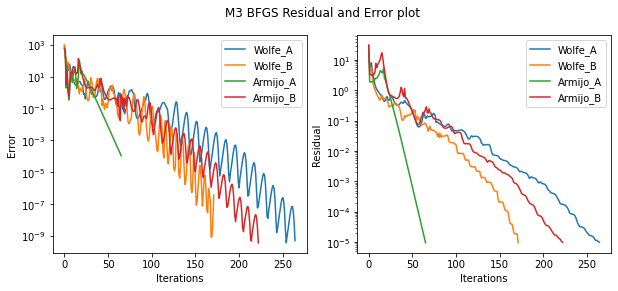

In [60]:
plot_summary(o_m3_errors_list, o_m3_residuals_list, labels_list, "M3", "BFGS")

#### Average runtime over 10 runs (Wolfe-type line search)

In [61]:
%%timeit -r 10
# Measuring running time
w_o_m3_bfgs_a.bfgs()

38.2 s ± 2.67 s per loop (mean ± std. dev. of 10 runs, 1 loop each)


In [62]:
%%timeit -r 10
# Measuring running time
w_o_m3_bfgs_b.bfgs()

20.9 s ± 183 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


#### Average runtime over 10 runs (Armijo-type line search)

In [63]:
%%timeit -r 10
# Measuring running time
a_o_m3_bfgs_a.bfgs()

7.75 s ± 113 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


In [64]:
%%timeit -r 10
# Measuring running time
a_o_m3_bfgs_b.bfgs()

27.3 s ± 2.52 s per loop (mean ± std. dev. of 10 runs, 1 loop each)


#### Comparison with off-shelf BFGS minimizer

In [65]:
off_shelf_opt(M3, x0_m3)
funcs = Funcs(M3)

Convergence reached in 294 iterations
Computed Norm: 41.065553271820015
True Norm: 41.06555327364635
Error: 1.826336415433616e-09


In [66]:
%%timeit -r 10
# Measuring running time
minimize(funcs.func_, x0_m3, method='BFGS', jac=funcs.func_grad_, options={'gtol': 1e-6, 'disp': False})

34.4 s ± 489 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


#### Comparison with off-shelf norm function

In [69]:
%%timeit -r 10
# Measuring running time
la.norm(M3, 2)

10.3 ms ± 1.06 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


### Cautious BFGS

In [70]:
c_m3_errors_list = []
c_m3_residuals_list = []

#### Base performance with loaded starting point (Wolfe-type line search)

In [71]:
w_c_m3_bfgs_a, w_c_m3_residuals_a, w_c_m3_errors_a = run_bfgs(M3, x0_m3, alg_method='C', ls_method='W', c1=1e-4, c2=0.9, return_arrays=True)
c_m3_errors_list.append(w_c_m3_errors_a)
c_m3_residuals_list.append(w_c_m3_residuals_a)

Convergence reached in 100 iterations
Computed Norm: 41.065553273638365
True Norm: 41.06555327364635
Error: 7.986500349943526e-12


In [72]:
w_c_m3_bfgs_b, w_c_m3_residuals_b, w_c_m3_errors_b = run_bfgs(M3, x0_m3, alg_method='C', ls_method='W', c1=0.1, c2=0.49, return_arrays=True)
c_m3_errors_list.append(w_c_m3_errors_b)
c_m3_residuals_list.append(w_c_m3_residuals_b)

Convergence reached in 75 iterations
Computed Norm: 41.065553273632354
True Norm: 41.06555327364635
Error: 1.3997691894473974e-11


#### Base performance with loaded starting point (Armijo-type line search)

In [73]:
a_c_m3_bfgs_a, a_c_m3_residuals_a, a_c_m3_errors_a = run_bfgs(M3, x0_m3, alg_method='C', ls_method='A', c1=1e-4, return_arrays=True)
c_m3_errors_list.append(a_c_m3_errors_a)
c_m3_residuals_list.append(a_c_m3_residuals_a)

Convergence reached in 117 iterations
Computed Norm: 41.065553273643665
True Norm: 41.06555327364635
Error: 2.6858515411731787e-12


In [74]:
a_c_m3_bfgs_b, a_c_m3_residuals_b, a_c_m3_errors_b = run_bfgs(M3, x0_m3, alg_method='C', ls_method='A', c1=0.1, return_arrays=True)
c_m3_errors_list.append(a_c_m3_errors_b)
c_m3_residuals_list.append(a_c_m3_residuals_b)

Convergence reached in 117 iterations
Computed Norm: 41.065553273643665
True Norm: 41.06555327364635
Error: 2.6858515411731787e-12


#### Summary for Cautious BFGS

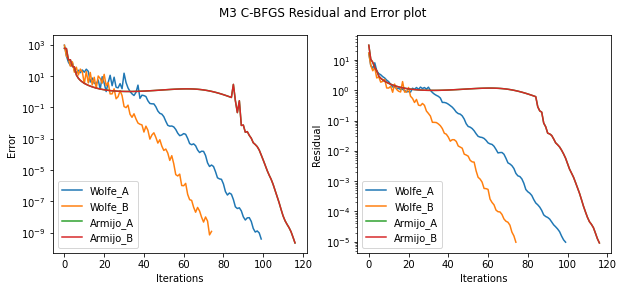

In [75]:
plot_summary(c_m3_errors_list, c_m3_residuals_list, labels_list, "M3", "C-BFGS")

#### Average runtime over 10 runs (Wolfe-type line search)

In [76]:
%%timeit -r 10
# Measuring running time
w_c_m3_bfgs_a.bfgs()

9.32 s ± 205 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


In [77]:
%%timeit -r 10
# Measuring running time
w_c_m3_bfgs_b.bfgs()

7.84 s ± 93.2 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


#### Average runtime over 10 runs (Armijo-type line search)

In [78]:
%%timeit -r 10
# Measuring running time
a_c_m3_bfgs_a.bfgs()

4.83 s ± 60.9 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


In [79]:
%%timeit -r 10
# Measuring running time
a_c_m3_bfgs_b.bfgs()

4.76 s ± 75.6 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


## M4 Matrix

### Original BFGS

In [80]:
o_m4_errors_list = []
o_m4_residuals_list = []

#### Base performance with loaded starting point (Wolfe-type line search)

In [81]:
w_o_m4_bfgs_a, w_o_m4_residuals_a, w_o_m4_errors_a = run_bfgs(M4, x0_m4, alg_method='O', ls_method='W', c1=1e-4, c2=0.9, return_arrays=True)
o_m4_errors_list.append(w_o_m4_errors_a)
o_m4_residuals_list.append(w_o_m4_residuals_a)

Convergence reached in 192 iterations
Computed Norm: 19.356959367506004
True Norm: 19.356959368936618
Error: 1.4306138496067433e-09


In [82]:
w_o_m4_bfgs_b, w_o_m4_residuals_b, w_o_m4_errors_b = run_bfgs(M4, x0_m4, alg_method='O', ls_method='W', c1=0.1, c2=0.49, return_arrays=True)
o_m4_errors_list.append(w_o_m4_errors_b)
o_m4_residuals_list.append(w_o_m4_residuals_b)

Convergence reached in 138 iterations
Computed Norm: 19.3569593673212
True Norm: 19.356959368936618
Error: 1.6154189097505878e-09


#### Base performance with loaded starting point (Armijo-type line search)

In [83]:
a_o_m4_bfgs_a, a_o_m4_residuals_a, a_o_m4_errors_a = run_bfgs(M4, x0_m4, alg_method='O', ls_method='A', c1=1e-4, return_arrays=True)
o_m4_errors_list.append(a_o_m4_errors_a)
o_m4_residuals_list.append(a_o_m4_residuals_a)

Convergence reached in 211 iterations
Computed Norm: 19.356959366896895
True Norm: 19.356959368936618
Error: 2.0397230571234104e-09


In [84]:
a_o_m4_bfgs_b, a_o_m4_residuals_b, a_o_m4_errors_b = run_bfgs(M4, x0_m4, alg_method='O', ls_method='A', c1=0.1, return_arrays=True)
o_m4_errors_list.append(a_o_m4_errors_b)
o_m4_residuals_list.append(a_o_m4_residuals_b)

Convergence reached in 211 iterations
Computed Norm: 19.356959366896895
True Norm: 19.356959368936618
Error: 2.0397230571234104e-09


#### Summary for Original BFGS

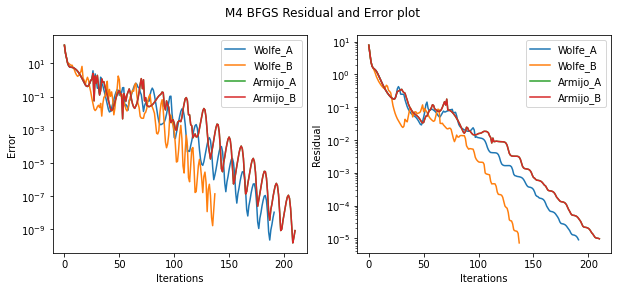

In [85]:
plot_summary(o_m4_errors_list, o_m4_residuals_list, labels_list, "M4", "BFGS")

#### Average runtime over 10 runs (Wolfe-type line search)

In [86]:
%%timeit -r 10
# Measuring running time
w_o_m4_bfgs_a.bfgs()

112 ms ± 17.3 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


In [87]:
%%timeit -r 10
# Measuring running time
w_o_m4_bfgs_b.bfgs()

91.6 ms ± 4.62 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


#### Average runtime over 10 runs (Armijo-type line search)

In [88]:
%%timeit -r 10
# Measuring running time
a_o_m4_bfgs_a.bfgs()

109 ms ± 17 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


In [89]:
%%timeit -r 10
# Measuring running time
a_o_m4_bfgs_b.bfgs()

118 ms ± 17.5 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


#### Comparison with off-shelf BFGS minimizer

In [90]:
off_shelf_opt(M4, x0_m4)
funcs = Funcs(M4)

Convergence reached in 55 iterations
Computed Norm: 18.42502730725014
True Norm: 19.356959368936618
Error: 0.9319320616864779


In [91]:
%%timeit -r 10
# Measuring running time
minimize(funcs.func_, x0_m4, method='BFGS', jac=funcs.func_grad_, options={'gtol': 1e-6, 'disp': False})

33 ms ± 1.81 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


#### Comparisonwith off-shelf norm function

In [92]:
%%timeit -r 10
# Measuring running time
la.norm(M4, 2)

1.36 ms ± 17.4 µs per loop (mean ± std. dev. of 10 runs, 1000 loops each)


### Cautious BFGS

In [93]:
c_m4_errors_list = []
c_m4_residuals_list = []

#### Base performance with loaded starting point (Wolfe-type line search)

In [94]:
w_c_m4_bfgs_a, w_c_m4_residuals_a, w_c_m4_errors_a = run_bfgs(M4, x0_m4, alg_method='C', ls_method='W', c1=1e-4, c2=0.9, return_arrays=True)
c_m4_errors_list.append(w_c_m4_errors_a)
c_m4_residuals_list.append(w_c_m4_residuals_a)

Convergence reached in 58 iterations
Computed Norm: 19.35695936892961
True Norm: 19.356959368936618
Error: 7.009504088273388e-12


In [95]:
w_c_m4_bfgs_b, w_c_m4_residuals_b, w_c_m4_errors_b = run_bfgs(M4, x0_m4, alg_method='C', ls_method='W', c1=0.1, c2=0.49, return_arrays=True)
c_m4_errors_list.append(w_c_m4_errors_b)
c_m4_residuals_list.append(w_c_m4_residuals_b)

Convergence reached in 50 iterations
Computed Norm: 19.356959368930855
True Norm: 19.356959368936618
Error: 5.7625015870144125e-12


#### Base performance with loaded starting point (Armijo-type line search)

In [96]:
a_c_m4_bfgs_a, a_c_m4_residuals_a, a_c_m4_errors_a = run_bfgs(M4, x0_m4, alg_method='C', ls_method='A', c1=1e-4, return_arrays=True)
c_m4_errors_list.append(a_c_m4_errors_a)
c_m4_residuals_list.append(a_c_m4_residuals_a)

Convergence reached in 53 iterations
Computed Norm: 19.356959368933875
True Norm: 19.356959368936618
Error: 2.7426949600339867e-12


In [97]:
a_c_m4_bfgs_b, a_c_m4_residuals_b, a_c_m4_errors_b = run_bfgs(M4, x0_m4, alg_method='C', ls_method='A', c1=0.1, return_arrays=True)
c_m4_errors_list.append(a_c_m4_errors_b)
c_m4_residuals_list.append(a_c_m4_residuals_b)

Convergence reached in 53 iterations
Computed Norm: 19.356959368933875
True Norm: 19.356959368936618
Error: 2.7426949600339867e-12


#### Summary for Cautious BFGS

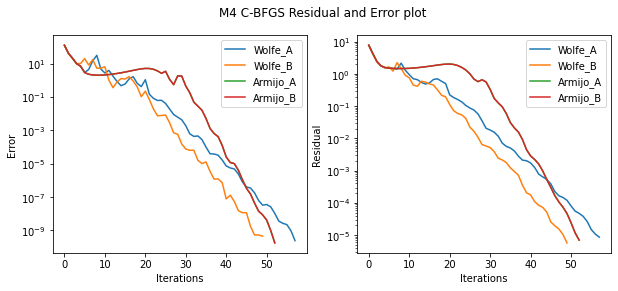

In [98]:
plot_summary(c_m4_errors_list, c_m4_residuals_list, labels_list, "M4", "C-BFGS")

#### Average runtime over 10 runs (Wolfe-type line search)

In [99]:
%%timeit -r 10
# Measuring running time
w_c_m4_bfgs_a.bfgs()

32.7 ms ± 1.68 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [100]:
%%timeit -r 10
# Measuring running time
w_c_m4_bfgs_b.bfgs()

31.3 ms ± 3.1 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


#### Average runtime over 10 runs (Armijo-type line search)

In [101]:
%%timeit -r 10
# Measuring running time
a_c_m4_bfgs_a.bfgs()

21.5 ms ± 1.25 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [102]:
%%timeit -r 10
# Measuring running time
a_c_m4_bfgs_b.bfgs()

22.2 ms ± 1.79 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


## M5 Matrix

### Original BFGS

In [103]:
o_m5_errors_list = []
o_m5_residuals_list = []

#### Base performance with loaded starting point (Wolfe-type line search)

In [104]:
w_o_m5_bfgs_a, w_o_m5_residuals_a, w_o_m5_errors_a = run_bfgs(M5, x0_m5, alg_method='O', ls_method='W', c1=1e-4, c2=0.9, return_arrays=True)
o_m5_errors_list.append(w_o_m5_errors_a)
o_m5_residuals_list.append(w_o_m5_residuals_a)

Convergence reached in 66 iterations
Computed Norm: 23.624892381956926
True Norm: 23.62489238197046
Error: 1.3535839116229909e-11


In [105]:
w_o_m5_bfgs_b, w_o_m5_residuals_b, w_o_m5_errors_b = run_bfgs(M5, x0_m5, alg_method='O', ls_method='W', c1=0.1, c2=0.49, return_arrays=True)
o_m5_errors_list.append(w_o_m5_errors_b)
o_m5_residuals_list.append(w_o_m5_residuals_b)

Convergence reached in 52 iterations
Computed Norm: 23.624892381944633
True Norm: 23.62489238197046
Error: 2.5828228444879642e-11


#### Base performance with loaded starting point (Armijo-type line search)

In [106]:
a_o_m5_bfgs_a, a_o_m5_residuals_a, a_o_m5_errors_a = run_bfgs(M5, x0_m5, alg_method='O', ls_method='A', c1=1e-4, return_arrays=True)
o_m5_errors_list.append(a_o_m5_errors_a)
o_m5_residuals_list.append(a_o_m5_residuals_a)

Convergence reached in 66 iterations
Computed Norm: 23.624892381956926
True Norm: 23.62489238197046
Error: 1.3535839116229909e-11


In [107]:
a_o_m5_bfgs_b, a_o_m5_residuals_b, a_o_m5_errors_b = run_bfgs(M5, x0_m5, alg_method='O', ls_method='A', c1=0.1, return_arrays=True)
o_m5_errors_list.append(a_o_m5_errors_b)
o_m5_residuals_list.append(a_o_m5_residuals_b)

Convergence reached in 66 iterations
Computed Norm: 23.624892381956926
True Norm: 23.62489238197046
Error: 1.3535839116229909e-11


#### Summary for Original BFGS

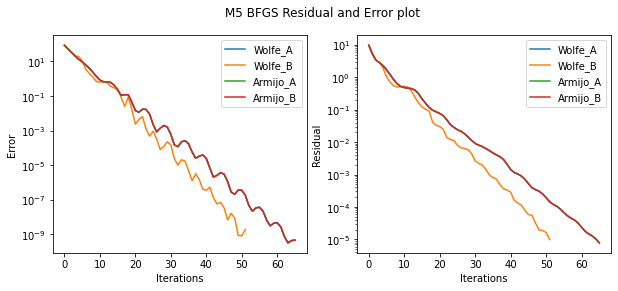

In [108]:
plot_summary(o_m5_errors_list, o_m5_residuals_list, labels_list, "M5", "BFGS")

#### Average runtime over 10 runs (Wolfe-type line search)

In [109]:
%%timeit -r 10
# Measuring running time
w_o_m5_bfgs_a.bfgs()

37.4 ms ± 2 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [110]:
%%timeit -r 10
# Measuring running time
w_o_m5_bfgs_b.bfgs()

34.3 ms ± 3.48 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


#### Average runtime over 10 runs (Armijo-type line search)

In [111]:
%%timeit -r 10
# Measuring running time
a_o_m5_bfgs_a.bfgs()

34.1 ms ± 1.91 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [112]:
%%timeit -r 10
# Measuring running time
a_o_m5_bfgs_b.bfgs()

35.2 ms ± 3.07 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


#### Comparison with off-shelf BFGS minimizer

In [113]:
off_shelf_opt(M5, x0_m5)
funcs = Funcs(M5)

Convergence reached in 57 iterations
Computed Norm: 23.624892381968756
True Norm: 23.62489238197046
Error: 1.7053025658242404e-12


In [114]:
%%timeit -r 10
# Measuring running time
minimize(funcs.func_, x0_m5, method='BFGS', jac=funcs.func_grad_, options={'gtol': 1e-6, 'disp': False})

33.1 ms ± 1.86 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


#### Comparisonwith off-shelf norm function

In [115]:
%%timeit -r 10
# Measuring running time
la.norm(M5, 2)

5.18 ms ± 1.26 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


### Cautious BFGS

In [116]:
c_m5_errors_list = []
c_m5_residuals_list = []

#### Base performance with loaded starting point (Wolfe-type line search)

In [117]:
w_c_m5_bfgs_a, w_c_m5_residuals_a, w_c_m5_errors_a = run_bfgs(M5, x0_m5, alg_method='C', ls_method='W', c1=1e-4, c2=0.9, return_arrays=True)
c_m5_errors_list.append(w_c_m5_errors_a)
c_m5_residuals_list.append(w_c_m5_residuals_a)

Convergence reached in 49 iterations
Computed Norm: 23.62489238196187
True Norm: 23.62489238197046
Error: 8.590461675339611e-12


In [118]:
w_c_m5_bfgs_b, w_c_m5_residuals_b, w_c_m5_errors_b = run_bfgs(M5, x0_m5, alg_method='C', ls_method='W', c1=0.1, c2=0.49, return_arrays=True)
c_m5_errors_list.append(w_c_m5_errors_b)
c_m5_residuals_list.append(w_c_m5_residuals_b)

Convergence reached in 40 iterations
Computed Norm: 23.624892381959825
True Norm: 23.62489238197046
Error: 1.06368247543287e-11


#### Base performance with loaded starting point (Armijo-type line search)

In [119]:
a_c_m5_bfgs_a, a_c_m5_residuals_a, a_c_m5_errors_a = run_bfgs(M5, x0_m5, alg_method='C', ls_method='A', c1=1e-4, return_arrays=True)
c_m5_errors_list.append(a_c_m5_errors_a)
c_m5_residuals_list.append(a_c_m5_residuals_a)

Convergence reached in 55 iterations
Computed Norm: 23.624892381965147
True Norm: 23.62489238197046
Error: 5.314859663485549e-12


In [120]:
a_c_m5_bfgs_b, a_c_m5_residuals_b, a_c_m5_errors_b = run_bfgs(M5, x0_m5, alg_method='C', ls_method='A', c1=0.1, return_arrays=True)
c_m5_errors_list.append(a_c_m5_errors_b)
c_m5_residuals_list.append(a_c_m5_residuals_b)

Convergence reached in 55 iterations
Computed Norm: 23.624892381965147
True Norm: 23.62489238197046
Error: 5.314859663485549e-12


#### Summary for Cautious BFGS

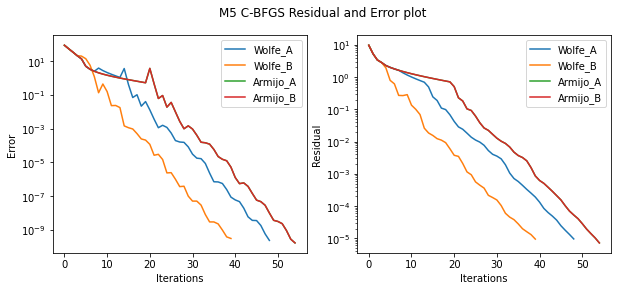

In [121]:
plot_summary(c_m5_errors_list, c_m5_residuals_list, labels_list, "M5", "C-BFGS")

#### Average runtime over 10 runs (Wolfe-type line search)

In [122]:
%%timeit -r 10
# Measuring running time
w_c_m5_bfgs_a.bfgs()

33.7 ms ± 8.77 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


In [123]:
%%timeit -r 10
# Measuring running time
w_c_m5_bfgs_b.bfgs()

30.3 ms ± 2.67 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


#### Average runtime over 10 runs (Armijo-type line search)

In [124]:
%%timeit -r 10
# Measuring running time
a_c_m5_bfgs_a.bfgs()

35.2 ms ± 14.5 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


In [125]:
%%timeit -r 10
# Measuring running time
a_c_m5_bfgs_b.bfgs()

29.4 ms ± 1.66 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)
